In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull

In [19]:
time_steps = np.arange(18, 23, 0.1)  # total number of time steps
for t_slot in time_steps:
    L = 48       # length of the foil
    U = 1        # velocity

    Pressure =  f"AOA_8_Pressure_L_48" + '/'
    df_foil = pd.read_csv('AOA_8_Coord_L_48/foil_coordinates_AOA_8.txt',delimiter='\s+')  # 或者 df = pd.read_csv('your_file.txt') 如果默认是逗号分隔
    df = df_foil.to_numpy()

    # calculate the symmetric axis, the one combining the start and end points of the foil
    p1 = df[0]
    p2 = df[-1]
    axis = p2 - p1

    # find all the symmetric points
    symmetric_data = np.empty_like(df)
    for i in range(len(df)):
        point = df[i]
        projection = p1 + np.dot(point - p1, axis) / np.dot(axis, axis) * axis
        symmetric_point = projection + (projection - point)
        symmetric_data[i] = symmetric_point

    # combine the original and symmetric foil, each is half of a foil）
    combined_data = np.vstack([df, symmetric_data[::-1]]) #[200,2]

    # combined_data[:,0] = combined_data[:,0]-18
    # combined_data[:,1] = combined_data[:,1]-14
    #fig, ax = plt.subplots(figsize=(5,3))
    #ax.plot(combined_data[:,0], combined_data[:,1])
    # ax.scatter(combined_data[50,0], combined_data[50,1], s=100)
    # ax.scatter(combined_data[100,0], combined_data[100,1], s=50)
    #plt.gca().set_aspect('equal', adjustable='box')
    pressure = np.loadtxt(f"{Pressure}flow_p_{t_slot:.1f}.txt")
    # plt.imshow(pressure,vmin=-0.2,vmax=0.2)
    # plt.plot(combined_data[:,0], combined_data[:,1],color='red')



In [20]:
# pressure_correct = np.flipud(np.rot90(pressure))
pressure_correct = pressure

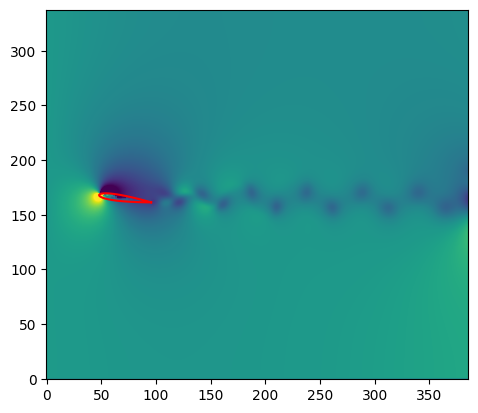

In [21]:
plt.imshow(pressure_correct,vmin=-0.2,vmax=0.2, origin='lower')
plt.plot(combined_data[:,0], combined_data[:,1],color='red')
# plt.axvline(x=48*2, color='b', linestyle='--')
# plt.axvline(x=48*2+48*0.25, color='r', linestyle='--')
# plt.axhline(y=48*2, color='b', linestyle='--')

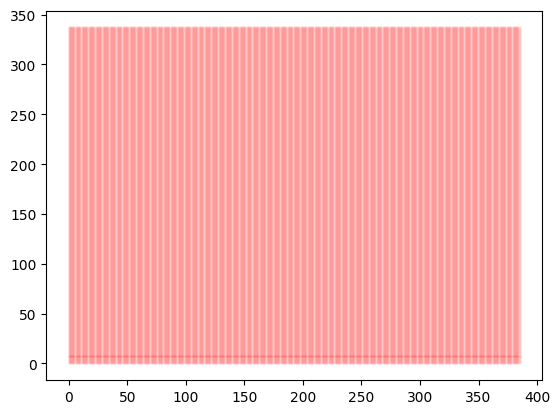

In [22]:
# create grid, prepare to interpolate
x = np.linspace(0, pressure_correct.shape[1]-1, pressure_correct.shape[1])
y = np.linspace(0, pressure_correct.shape[0]-1, pressure_correct.shape[0])
grid_x, grid_y = np.meshgrid(x, y)
# Show the grid using scatter
plt.scatter(grid_x, grid_y, color='red', marker='o', s=0.005, label='Grid Points')


In [23]:
grid_points = np.array([grid_x.flatten(), grid_y.flatten()]).T  # [N, 2]

data_flatten = pressure_correct.flatten()

# interpolate pressure to foil surface
interpolated_values = griddata(grid_points, data_flatten, combined_data, 
                               method='linear')

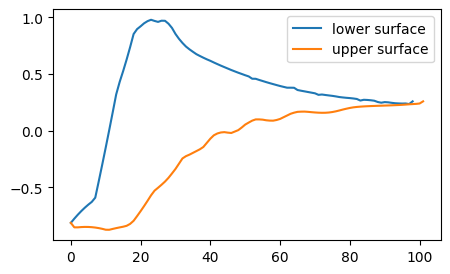

In [24]:
cp = (interpolated_values - 0.0) / (0.5*U**2)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(-np.flipud(cp[:98+1]), label='lower surface')
ax.plot(-cp[98:], label='upper surface')
ax.legend()

In [25]:
combindata = combined_data
pressuredata = interpolated_values   

# 使用凸包算法排序坐标点
hull = ConvexHull(combindata)
sorted_indices = hull.vertices
sorted_points = combindata[sorted_indices]
sorted_pressures = pressuredata[sorted_indices]

# ensure the path is closed, no repeated starting point
if sorted_indices[0] != sorted_indices[-1]:
    sorted_points = np.append(sorted_points, [sorted_points[0]], axis=0)
    sorted_pressures = np.append(sorted_pressures, sorted_pressures[0])

# find the vector and length of each line of the foil (not a smooth curve)
vectors = np.diff(sorted_points, axis=0)
lengths = np.linalg.norm(vectors, axis=1)
midpoints = (sorted_points[:-1] + sorted_points[1:]) / 2  # 计算线段的中点

# find the normal vector of each vector of foil
normals = np.array([vectors[:, 1], -vectors[:, 0]]).T
normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)

# find the two components of force, drag in x and lift in y
# normals are unit normal vectors
# * normals, to give the direction of pressure force
forces = sorted_pressures[:-1, None] * lengths[:, None] * normals

# flip the force back
forces = - forces

F_x = np.sum(forces[:, 0])
F_y = np.sum(forces[:, 1])

# find CL and CD
CD = F_x / (0.5*L*U**2)
CL = F_y / (0.5*L*U**2)

# print force
print(f"CD = : {CD}")
print(f"CL = : {CL}")

CD = : 0.09071196742292043
CL = : 0.31364909674165853


In [26]:
import pandas as pd

# 读取 CSV 文件--别人的paper
df = pd.read_csv('Paper/cp_aoa_8.csv')

# 看一下前几行数据
print(df.head())
df = df.to_numpy()

   -0.003419149849803793   0.8165804034391191
0              -0.003256             0.577457
1              -0.003617             0.156045
2              -0.002052             1.097574
3              -0.001344            -0.319075
4               0.000002            -0.386943


In [27]:
# 找到前缘和后缘的坐标（x 最小和最大）
x_min_idx = np.argmin(combined_data[:, 0])  # 找到 x 最小的索引
x_max_idx = np.argmax(combined_data[:, 0])  # 找到 x 最大的索引

# 获取前缘和后缘的坐标
front_edge = combined_data[x_min_idx]
rear_edge = combined_data[x_max_idx]

# 计算弦长（欧几里得距离）
chord_length = np.sqrt((rear_edge[0] - front_edge[0])**2 + (rear_edge[1] - front_edge[1])**2)
normalized_x = (combined_data[:, 0] - front_edge[0]) / chord_length

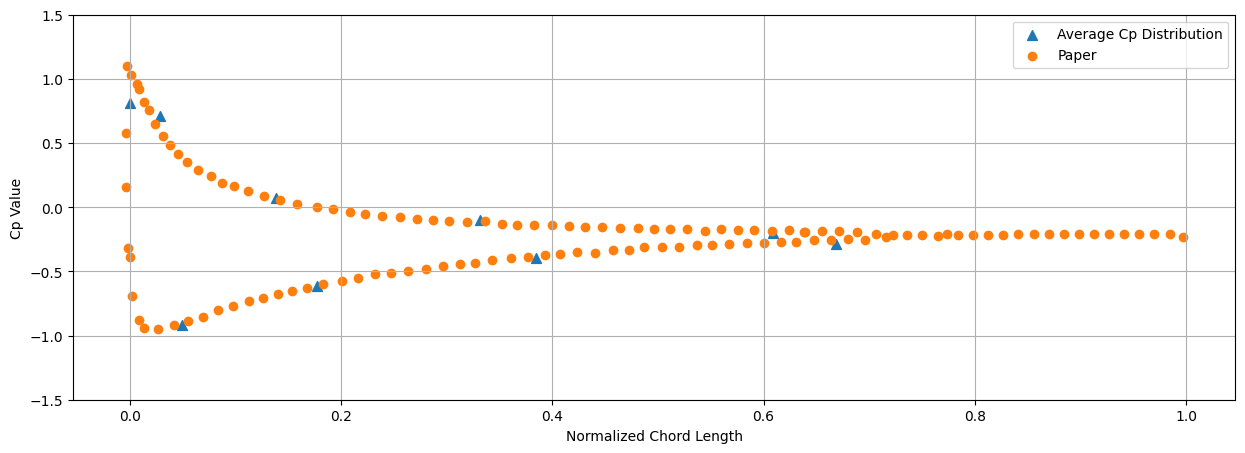

In [28]:
import matplotlib.pyplot as plt

# 选定的索引
idxs = [98-20*4, 98-20*3, 98-20*2, 98-20, 98, 98+20, 98+20*2, 98+20*3, 98+20*4]

plt.figure(figsize=(15, 5))
plt.scatter(normalized_x[idxs], cp[idxs], label="Average Cp Distribution",marker='^',s=50)
plt.scatter(df[::1,0], df[::1,1], label="Paper")
plt.xlabel("Normalized Chord Length")
plt.ylabel("Cp Value")
plt.ylim(-1.5, 1.5)  # 设置 y 轴坐标范围
plt.legend()
plt.grid(True)
plt.show()

In [29]:
normalized_x.shape

(200,)

In [33]:
 #baocun
import pandas as pd
df = pd.DataFrame({
    'normalized_x': normalized_x,
    'cp': cp
})
df.to_csv('Our cp.csv', index=False)